# Fugue with DuckDB

[DuckDB](https://duckdb.org/) is an in-process SQL OLAP database management system. The speed is very good on even gigabytes of data on local machines.
Fugue has a deep integration with DuckDB. Fugue not only uses DuckDB as the SQL engine, but also implemented all [execution engine](../advanced/execution_engine.ipynb) methods using DuckDB SQL and relations. So in most part of the workflow, the data tables are kept in DuckDB and in rare cases
the tables will be materialized and converted to arrow dataframes. Note this [blog](https://duckdb.org/2021/12/03/duck-arrow.html) explains that converting
between DuckDB and Arrow has minimal overhead.

## Installation

```bash
pip install fugue[duckdb,sql]
```

## Hello World

To use it prgrammatically, you only need to

In [1]:
import fugue_duckdb

This is to register all the types and execution engines of DuckDB. Then you can write a hello world:

In [2]:
from fugue_sql import fsql
import pandas as pd

df = pd.DataFrame(dict(a=[0,1,1,2], b=[10,20,30,40]))

fsql("""
SELECT a, SUM(b) AS b FROM df GROUP BY a
PRINT
""", df=df).run("duckdb")

DuckDataFrame
a:long|b:long
------+------
0     |10    
1     |50    
2     |40    
Total count: 3



DataFrames()

Now, let's consider the notebook use case

In [3]:
from fugue_notebook import setup

setup()

<IPython.core.display.Javascript object>

## A Practical Workflow

In this workflow, we will create some mock dataframes, save to csv, load it and save to parquet, and do some basic EDA on the dataframes.

### Create data and save and load

In [4]:
import numpy as np

np.random.seed(0)
n = 1000

df1 = pd.DataFrame(dict(
    a = np.random.choice(["a", "b", "c"], n),
    b = np.random.rand(n),
    c = pd.date_range(start="2020-01-01 14:15:16", periods=n, freq="s")
))

df2 = pd.DataFrame(dict(
    c = pd.date_range(start="2020-01-01 14:15:16", periods=n, freq="s"),
    d = np.random.choice([True, False, None], n),
))

In [5]:
%%fsql duck
PRINT df1, df2

,a,b,c
0,a,0.671383,2020-01-01 14:15:16
1,b,0.344718,2020-01-01 14:15:17
2,a,0.713767,2020-01-01 14:15:18
3,b,0.639187,2020-01-01 14:15:19
4,b,0.399161,2020-01-01 14:15:20
5,c,0.431760,2020-01-01 14:15:21
6,a,0.614528,2020-01-01 14:15:22
7,c,0.070042,2020-01-01 14:15:23
8,a,0.822407,2020-01-01 14:15:24
9,a,0.653421,2020-01-01 14:15:25


,c,d
0,2020-01-01 14:15:16,None
1,2020-01-01 14:15:17,None
2,2020-01-01 14:15:18,None
3,2020-01-01 14:15:19,True
4,2020-01-01 14:15:20,True
5,2020-01-01 14:15:21,True
6,2020-01-01 14:15:22,None
7,2020-01-01 14:15:23,None
8,2020-01-01 14:15:24,True
9,2020-01-01 14:15:25,False


In [6]:
%%fsql duck
SAVE df1 OVERWRITE "/tmp/df1.csv" (header=TRUE)
SAVE df2 OVERWRITE "/tmp/df2.csv" (header=FALSE)

Load back CSVs and save to parquets. Parquet is always a better choice than CSV

In [7]:
%%fsql duck
LOAD "/tmp/df1.csv" (header=TRUE, infer_schema=TRUE)
SAVE OVERWRITE "/tmp/df1.parquet"
LOAD "/tmp/df2.csv" COLUMNS c:datetime,d:bool
SAVE AND USE OVERWRITE "/tmp/df2.parquet"
PRINT

,c,d
0,2020-01-01 14:15:16,None
1,2020-01-01 14:15:17,None
2,2020-01-01 14:15:18,None
3,2020-01-01 14:15:19,True
4,2020-01-01 14:15:20,True
5,2020-01-01 14:15:21,True
6,2020-01-01 14:15:22,None
7,2020-01-01 14:15:23,None
8,2020-01-01 14:15:24,True
9,2020-01-01 14:15:25,False


### Basic EDA

In [8]:
%%fsql duck
df1 = LOAD "/tmp/df1.parquet"
df2 = LOAD "/tmp/df2.parquet"
df3 = 
    SELECT df1.*, df2.d FROM df1 INNER JOIN df2 ON df1.c = df2.c
    YIELD DATAFRAME

PRINT ROWCOUNT

,a,b,c,d
0,c,0.800256,2020-01-01 14:23:24,False
1,b,0.955568,2020-01-01 14:23:25,None
2,b,0.316550,2020-01-01 14:23:26,True
3,b,0.826805,2020-01-01 14:23:27,True
4,a,0.103991,2020-01-01 14:23:28,True
5,a,0.633982,2020-01-01 14:23:29,None
6,c,0.751032,2020-01-01 14:23:30,False
7,a,0.155978,2020-01-01 14:23:31,None
8,a,0.426002,2020-01-01 14:23:32,False
9,c,0.892707,2020-01-01 14:23:33,True


The yielded `df3` can be directly used on the next cells. `YIELD DATAFRAME` or `YIELD FILE` are extremely useful for EDA step.

In [9]:
%%fsql duck
top2 = SELECT a, SUM(b) AS b FROM df3 GROUP BY a ORDER BY b DESC LIMIT 2
top_groups = SELECT df3.* FROM df3 INNER JOIN top2 ON df3.a = top2.a YIELD DATAFRAME
PRINT ROWCOUNT

SELECT minute(c) AS m, COUNT(*) AS ct GROUP BY 1 ORDER BY 2 DESC
PRINT

,a,b,c,d
0,b,0.268709,2020-01-01 14:23:23,False
1,c,0.024577,2020-01-01 14:23:20,None
2,b,0.349898,2020-01-01 14:23:18,None
3,c,0.276650,2020-01-01 14:23:16,False
4,b,0.683726,2020-01-01 14:23:13,True
5,c,0.102446,2020-01-01 14:23:14,False
6,b,0.221218,2020-01-01 14:23:12,True
7,c,0.280859,2020-01-01 14:23:05,True
8,b,0.392319,2020-01-01 14:23:11,True
9,c,0.128021,2020-01-01 14:22:58,True


,m,ct
0,24,46
1,25,45
2,28,43
3,19,42
4,26,42
5,31,41
6,30,40
7,17,39
8,18,39
9,22,39


And a couple of Fugue SQL specific syntax

In [10]:
%%fsql duck
TAKE 2 ROWS FROM top_groups PREPARTITION BY a PRESORT b
PRINT

FILL NULLS PARAMS d:TRUE FROM top_groups
PRINT

SAMPLE 1 PERCENT SEED 0 FROM top_groups 
PRINT ROWCOUNT

DROP ROWS IF ANY NULLS FROM top_groups
PRINT ROWCOUNT

DROP COLUMNS b, x IF EXISTS FROM top_groups
PRINT

,a,b,c,d
0,b,0.000546,2020-01-01 14:17:51,True
1,b,0.024273,2020-01-01 14:21:34,True
2,c,0.001383,2020-01-01 14:16:47,None
3,c,0.004655,2020-01-01 14:24:44,True


,a,b,c,d
0,c,0.800256,2020-01-01 14:23:24,False
1,b,0.955568,2020-01-01 14:23:25,True
2,b,0.316550,2020-01-01 14:23:26,True
3,b,0.826805,2020-01-01 14:23:27,True
4,c,0.751032,2020-01-01 14:23:30,False
5,c,0.892707,2020-01-01 14:23:33,True
6,b,0.103578,2020-01-01 14:23:34,False
7,c,0.018096,2020-01-01 14:23:35,True
8,c,0.590585,2020-01-01 14:23:36,True
9,c,0.798689,2020-01-01 14:23:38,False


,a,b,c,d
0,b,0.842973,2020-01-01 14:28:39,None
1,b,0.690785,2020-01-01 14:16:16,True
2,b,0.923305,2020-01-01 14:18:31,None
3,b,0.727547,2020-01-01 14:18:50,None
4,b,0.141817,2020-01-01 14:21:30,True


,a,b,c,d
0,c,0.800256,2020-01-01 14:23:24,False
1,b,0.316550,2020-01-01 14:23:26,True
2,b,0.826805,2020-01-01 14:23:27,True
3,c,0.751032,2020-01-01 14:23:30,False
4,c,0.892707,2020-01-01 14:23:33,True
5,b,0.103578,2020-01-01 14:23:34,False
6,c,0.018096,2020-01-01 14:23:35,True
7,c,0.590585,2020-01-01 14:23:36,True
8,c,0.798689,2020-01-01 14:23:38,False
9,c,0.388404,2020-01-01 14:23:41,False


,a,c,d
0,c,2020-01-01 14:23:24,False
1,b,2020-01-01 14:23:25,None
2,b,2020-01-01 14:23:26,True
3,b,2020-01-01 14:23:27,True
4,c,2020-01-01 14:23:30,False
5,c,2020-01-01 14:23:33,True
6,b,2020-01-01 14:23:34,False
7,c,2020-01-01 14:23:35,True
8,c,2020-01-01 14:23:36,True
9,c,2020-01-01 14:23:38,False


## Extensions

For transformers, since DuckDB is a SQL solution, custom python code will be using NativeExecutionEngine to execute. They will not run in parallel, but they should provide consistent result when you switch to distributed execution engines.

In [11]:
import pandas as pd

# schema: *
def get_median(df:pd.DataFrame) -> pd.DataFrame:
    return df.head(1).assign(b=df.b.median())

In [12]:
%%fsql duck
SELECT a,b FROM (LOAD "/tmp/df1.parquet")
TRANSFORM PREPARTITION BY a USING get_median
PRINT

,a,b
0,a,0.480061
1,b,0.531494
2,c,0.507267


For driver side extensions such as Creator, Processor and Outputter, you can use [DuckDBPyConnection](https://github.com/duckdb/duckdb/blob/8a0e93080023f4d3226a2021a7697fd0299bf2b8/tools/pythonpkg/duckdb-stubs/__init__.pyi#L22) as the engine input and [DuckDBPyRelation](https://github.com/duckdb/duckdb/blob/8a0e93080023f4d3226a2021a7697fd0299bf2b8/tools/pythonpkg/duckdb-stubs/__init__.pyi#L64) as the dataframe input. 

The purpose is that you can write modulized code that is completely independent from Fugue, but in the end you can use Fugue to orchestrate them. But you need to understand that, by using DuckDB specific input in an extension, it can only work with DuckDB execution engine.

In [13]:
from duckdb import DuckDBPyConnection, DuckDBPyRelation
import pyarrow as pa

def my_create(con:DuckDBPyConnection) -> DuckDBPyRelation:
    return con.query("SELECT 'a' AS a, 0.2 AS z")

def my_process1(df:DuckDBPyRelation) -> pd.DataFrame:
    return df.project("*, b*2 AS c").df()

def my_process2(df:DuckDBPyRelation) -> pa.Table:
    return df.project("*, b*3 AS d").arrow()

def my_process3(df:pd.DataFrame) -> pd.DataFrame:
    return df.assign(e=df.b*4)

def my_output(df:DuckDBPyRelation) -> None:
    df.df().hist(column=["b","c","d","e"])

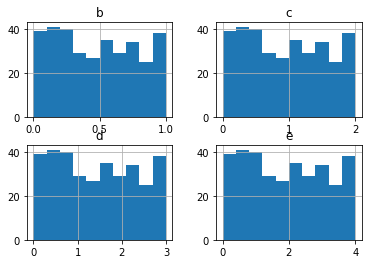

In [14]:
%%fsql duck
df2 = CREATE USING my_create
df1 = LOAD "/tmp/df1.parquet" COLUMNS a,b
SELECT df1.*, z FROM df1 INNER JOIN df2 ON df1.a = df2.a
PROCESS USING my_process1
PROCESS USING my_process2
PROCESS USING my_process3
OUTPUT USING my_output


## Functional API

Just like all other Fugue execution engines, you can use functional API instead of SQL. Here is the same logic as the above SQL:

DataFrames()

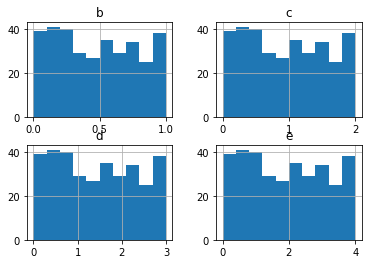

In [15]:
from fugue import FugueWorkflow

dag = FugueWorkflow()
df2 = dag.create(my_create)
df1 = dag.load("/tmp/df1.parquet", columns=["a","b"])
df3 = df1.inner_join(df2)
df3.process(my_process1).process(my_process2).process(my_process3).output(my_output)

dag.run("duckdb")

## Ibis Support

You can use Ibis interface with DuckDB, for the following code

In [25]:
%%fsql duck
df1 = LOAD "/tmp/df1.parquet"
top2 = SELECT a, SUM(b) AS b GROUP BY a ORDER BY b DESC LIMIT 2
top_groups = SELECT df1.* FROM df1 INNER JOIN top2 ON df1.a = top2.a
SELECT minute(c) AS m, COUNT(*) AS ct GROUP BY 1 ORDER BY 2 DESC
PRINT 2 ROWS

,m,ct
0,24,46
1,25,45


The equivalent Fugue+Ibis expression will be:

In [26]:
import fugue_ibis
import ibis

dag = FugueWorkflow()
df1 = dag.load("/tmp/df1.parquet").as_ibis()
top2 = df1.groupby("a").aggregate(df1.b.sum().name("b")).sort_by(ibis.desc("b")).limit(2)
top_groups = df1.inner_join(top2, "a")[df1]
res = top_groups.groupby(top_groups.c.minute().name("m")).aggregate(df1.count().name("ct")).sort_by(ibis.desc("ct"))
res.as_fugue().show(2)

dag.run("duck");


,m,ct
0,24,46
1,25,45


## DuckDB vs Pandas as Fugue Backend

If only comparing DuckDB and Pandas without considering Fugue, they both have pros and cons.

The pros of Pandas:

* It's feature rich.
* It has great documentation and large amount of online examples.
* It has strong community support.

The cons of Pandas:

* It's unnecessarily fat, see this [blog](https://medium.com/dunder-data/minimally-sufficient-pandas-a8e67f2a2428).
* It's slower and it consumes more memory compared to many other alternatives.
* It has strong assumption that the computation happens locally in memory (e.g. implicit schema, global sort, index).
* The data types is a mess.

The pros of DuckDB:

* It's SQL based. SQL is great of scale agnostic computing. The same SQL may be used on distributed system with little or no modification.
* It's extremely fast even on gigabytes of data, and the memory use is minimal too.
* It's extremely lightweight, as of 0.3.1, the duckdb python package has no extra dependency.

The cons of DuckDB:

* It's not as feature rich as Pandas, and not as capable as Pandas for scientific computing.
* It's relatively new and has less online examples.
* It may have more bugs and more crash (segment fault) than Pandas. (With proper usage, this isn't obvious)

In addition, Pandas and DuckDB have slightly different licences (BSD-3 vs MIT). DuckDB has very good support on Pandas dataframes.
The data transfer is much faster than SQLite. Also compared to SQLite, DuckDB has a lot more data types, making it a more practical choice
for python users.

On the Fugue layer, the DuckDB execution engine is built majorly on DuckDB itself. Most of the methods are implemented directly using DuckDB's
SQL and [DuckDBPyRelation](https://github.com/duckdb/duckdb/blob/8a0e93080023f4d3226a2021a7697fd0299bf2b8/tools/pythonpkg/duckdb-stubs/__init__.pyi#L64).
Only a few methods, such as [map](https://github.com/fugue-project/fugue/blob/fa9d3d1b397af7835c0e4b78205228ae0877bcf5/fugue_duckdb/execution_engine.py#L162) are using `NativeExecutionEngine`'s implementation.

This design keeps the data inside DuckDB through the workflow in most cases, so it can minimize the data transfer/conversion overhead, and it can take advantage of DuckDB's lazy evaluation. For example in the following code:

```sql
LOAD "...parquet"
SELECT a, SUM(b) AS b GROUP BY a
PRINT
```

Only the `PRINT` will trigger the previous steps to materialize. With lazy evaluation, the workflow can push down the column filtering of parquet
to the load step. Because `SELECT` only requires columns `a` and `b`, DuckDB actually only loaded the two columns of data from the parquet file, makeing
the whole process faster. In addition, all data is processed inside DuckDB without any data conversion and transfer until print step needs to fetch
a few rows from DuckDB to render. Let's look at another example:

```sql
LOAD "...csv"(header=true)
PRINT
```

Assume the CSV file is very large, the load and print will take no time. Because `PRINT` by default only needs to get 10 rows from the
previous step, it pushes down the limit to the loading step, so only a small portion of the CSV file was actually loaded.

In contrast, if you use `NativeExecutionEngine` (Pandas) as the backend, there is no lazy execution, so the load step will always load all data, making it
less practical for data analysis.

In addition, DuckDB as a SQL engine, the SQL support (including syntax and functions) is much better than `NativeExecutionEngine`'s default SQL backend
[QPD](https://pypi.org/project/qpd/). So again, this makes data analysis on a single machine more practical.

On the other hand, since Fugue DuckDB engine is backed by `NativeExecutionEngine`, it can also take full advantage of Pandas' rich features, in an
appropriate way. We don't believe Pandas interface or the mindset behind it is right for distributed computing. In Fugue, users can heavily rely on Pandas
for **local computing**, meaning that the appropriate places to use Pandas in Fugue is in transformers. Since DuckDB engine fully supports transformers, you can combine the strengths of DuckDB and Pandas in this way.

So what is the value that Fugue adds to DuckDB?

* **SQL end to end**: Fugue treats each SQL statement as an operator and chains them together, making it intuitive to express entire workflows with SQL.
* **Pythonic expressions**: for users who prefer functional APIs, Fugue enables functional API including Ibis to use DuckDB.
* **Minimal coding**: it further minimizes the boilerplate code of DuckDB.
* **Seamless integration**: you can easily integrate Pandas code into the workflow, so you can enjoys the pros of both DuckDB and Pandas.
* **Seamless migration**: when your data size is too big for a single machine, you just need to switch to a distributed Fugue engine with no code change.

To sum up, using DuckDB as your Fugue backend:

* It's more practical to do data analysis on a single machine. Even with gigabyte level data, the speed can be very good.
* You can also use it to quickly iterate on the logic you want to ultimately run on Spark or Dask. It will be faster and more seamless than using `NativeExecutionEngine`.

If you don't mind adding duckdb as a dependency, it's a wonderful local execution engine for Fugue.
